In [1]:
import pandas as pd
import random
import datetime
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import catboost as ctb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tqdm
from scipy.cluster import hierarchy

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

def DTWDistance(s1, s2,w = 5):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

%matplotlib inline

In [4]:
data_path = './'

# Load data

In [5]:
# card data
train = pd.read_csv(data_path + 'train.csv')
train = train[train.card_id.isin(random.sample(list(train.card_id.unique()), 15000))]
train.reset_index(inplace=True, drop = True)
train.head(1)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-09,C_ID_dfa21fc124,3,2,1,2.13585


In [6]:
# transactions data
tr_df = pd.read_csv(data_path + 'historical_transactions.csv' )
tr_df.purchase_date = pd.DatetimeIndex(tr_df.purchase_date)
tr_df.reset_index(inplace=True, drop = True)
tr_df = tr_df[tr_df.card_id.isin(train.card_id.unique())]
tr_df.head(1)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
5430,Y,C_ID_3917d75318,140,N,0,A,307,M_ID_e31347350b,-8,-0.737892,2017-06-27 06:47:51,1.0,9,19


# Get some features for card from transactions

In [7]:
# transaction number for card id
num_of_card_transactionis_df = tr_df.groupby(['card_id']).size().reset_index().rename(columns = {0: 'card_num_transactions'})
train = train.merge(num_of_card_transactionis_df, how = 'left', on = 'card_id')

# remove outlier users by 3 sigma of transactions on cards
train.card_num_transactions = np.log(train.card_num_transactions)
sigma2 = train.card_num_transactions.mean() + 2 * train.card_num_transactions.std()
train = train[train.card_num_transactions < sigma2]
train.reset_index(inplace=True, drop = True)
train.card_num_transactions = np.exp(train.card_num_transactions)

# add card spendings
card_spendings_mean = tr_df.groupby(['card_id'], as_index=False).purchase_amount.mean().rename(columns={'purchase_amount':'purchase_amount_mean'})
train = train.merge(card_spendings_mean, on = 'card_id', how = 'left')

# remove outlier users by 3 sigma of purchase mean
train.purchase_amount_mean = np.log(train.purchase_amount_mean+1)
sigma2 = train.purchase_amount_mean.mean() + 2 * train.purchase_amount_mean.std()
train = train[train.purchase_amount_mean < sigma2]
train.reset_index(inplace=True, drop = True)
train.purchase_amount_mean = np.exp(train.purchase_amount_mean)-1

train.head(1)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,card_num_transactions,purchase_amount_mean
0,2017-09,C_ID_dfa21fc124,3,2,1,2.13585,22.0,-0.616629


# Baseline elo

In [8]:
elo_train_columns = ['feature_1', 'feature_2', 'feature_3', 'card_num_transactions', 'purchase_amount_mean']
x_train, x_test, y_train, y_test= train_test_split(train[elo_train_columns], train['target'], random_state = 42)

params = {
    'thread_count':22,
    'learning_rate':0.3,
    'random_seed':1
}

catb_cv = ctb.cv(pool = ctb.Pool(x_train, y_train), params=params, nfold=10, num_boost_round = 10000, early_stopping_rounds=25, verbose_eval=False)
best_it = catb_cv.shape[0]
print('baseline best_it:', best_it)

ctb_model = ctb.train(pool = ctb.Pool(x_train, y_train), params=params, num_boost_round = best_it, verbose_eval=False)
base_error = np.sqrt(mean_squared_error(y_test, ctb_model.predict(x_test)))
print('baseline rmse:', base_error)

baseline best_it: 31
baseline rmse: 4.095904301012796


# Baseline clustering

In [9]:
# prepare data for clustering
cluster_columns = ['card_num_transactions', 'purchase_amount_mean']#, 'feature_1_enc', 'feature_2_enc', 'feature_3_enc']
x_train, x_test, y_train, y_test= train_test_split(train[cluster_columns], train['target'], random_state = 42)

ss = StandardScaler()
x_train.loc[:, :] = ss.fit_transform(x_train)
x_test.loc[:, :] = ss.transform(x_test)

New best silhouette score: 0.4749185921132625 , with 2 number of clusters.
New best silhouette score: 0.5349024627585408 , with 3 number of clusters.


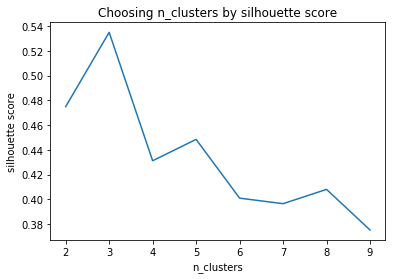

In [10]:
# find best num of clusters by silhouette score
best_n_clusters = 0
best_sil_score = 0
sil_scores= []
x = np.arange(2, 10)
for n_clusters in x:
    km = KMeans(n_clusters = n_clusters, random_state=42, n_jobs=-1)
    km.fit(x_train)
    sil_score = silhouette_score(x_train.values, km.predict(x_train), sample_size=10000)
    sil_scores.append(sil_score)
    if sil_score > best_sil_score:
        not_better = 0
        best_sil_score = sil_score
        best_n_clusters = n_clusters
        print('New best silhouette score:', sil_score, ', with', n_clusters, 'number of clusters.')

plt.plot(x, sil_scores)
plt.title('Choosing n_clusters by silhouette score')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.show()

In [11]:
# fit alg
km = KMeans(n_clusters = best_n_clusters, random_state=42, n_jobs=-1)
km.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc2ee5780>]],
      dtype=object)

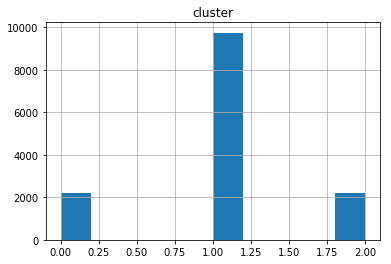

In [12]:
# predict clusters 
train.loc[x_train.index, 'cluster'] = km.predict(x_train)
train.loc[x_test.index, 'cluster'] = km.predict(x_test)
train.hist(column='cluster')

**cluster visualization**

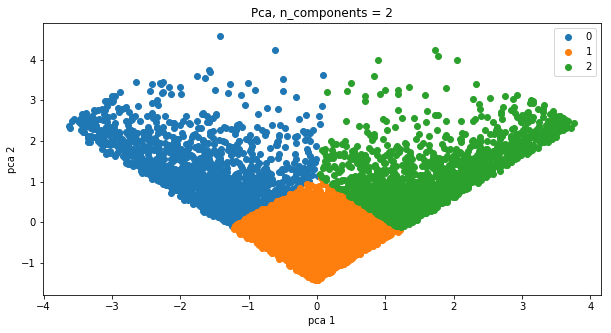

In [13]:
pca = PCA(n_components=2)
plot_df = x_train.copy()
x_train_pca = pca.fit_transform(x_train)
plot_df['pca_1'] = x_train_pca[:, 0]
plot_df['pca_2'] = x_train_pca[:, 1]
plot_df['cluster'] = km.predict(x_train)

plt.figure(figsize=(10, 5))
for cluster, group in plot_df.groupby(['cluster']):
    plt.scatter(group.pca_1, group.pca_2, label = cluster)
plt.legend()
plt.xlabel('pca 1')
plt.ylabel('pca 2')
plt.title('Pca, n_components = 2')
plt.show()

**adding cluster as a feature**

In [14]:
x_train, x_test, y_train, y_test= train_test_split(train[elo_train_columns + ['cluster']], train['target'], random_state = 42)

catb_cv = ctb.cv(pool = ctb.Pool(x_train, y_train), params=params, nfold=10, num_boost_round = 10000, early_stopping_rounds=25, verbose_eval=False)
best_it = catb_cv.shape[0]
print('baseline best_it:', best_it)

ctb_model = ctb.train(pool = ctb.Pool(x_train, y_train), params=params, num_boost_round = best_it, verbose_eval=False)
single_clustering_error = np.sqrt(mean_squared_error(y_test, ctb_model.predict(x_test)))
print('single clustering rmse:', single_clustering_error)

diff_error = base_error - single_clustering_error
if diff_error > 0:
    print('Error improved by:', diff_error)
else:
    print('Error worsen by:', diff_error)

baseline best_it: 29
single clustering rmse: 4.094134212934841
Error improved by: 0.0017700880779552008


# Time series clustering for cards

In [15]:
# group to dayofweek sales
tr_df_daily = tr_df.copy()
tr_df_daily.purchase_date = pd.DatetimeIndex(tr_df_daily.purchase_date).dayofweek
tr_df_daily = tr_df_daily.groupby(['card_id', 'purchase_date'], as_index = False)['purchase_amount'].median()
tr_df_daily.sort_values(['card_id', 'purchase_date'], inplace=True)
tr_df_daily.reset_index(inplace = True, drop = True)
print('Total c_id in dataset:', tr_df_daily.card_id.nunique())
tr_df_daily.head(1)

Total c_id in dataset: 15000


,card_id,purchase_date,purchase_amount
0,C_ID_0003be3c83,0,-0.693939


In [16]:
%%time
# min max scaler
from sklearn.preprocessing import MinMaxScaler
for m_id, group in tr_df_daily.groupby(['card_id']):
    tr_df_daily.loc[group.index, 'purchase_amount_exp_minmax'] = MinMaxScaler().fit_transform(group['purchase_amount'].values.reshape(-1, 1))

CPU times: user 24.3 s, sys: 21 ms, total: 24.4 s
Wall time: 24.4 s


In [17]:
# take subset for train
subset_size = 5000
skip_size = 500
card_id_subset = tr_df_daily.groupby(['card_id']).size().reset_index().sort_values(0, ascending = False).card_id.values[skip_size:skip_size+subset_size]
tr_df_daily_train = tr_df_daily[tr_df_daily.card_id.isin(card_id_subset)].copy()
print('Number of c_id in train:', tr_df_daily_train.card_id.nunique())
tr_df_daily_train.head(1)

Number of c_id in train: 5000


,card_id,purchase_date,purchase_amount,purchase_amount_exp_minmax
7,C_ID_000c778b05,0,-0.699439,0.0


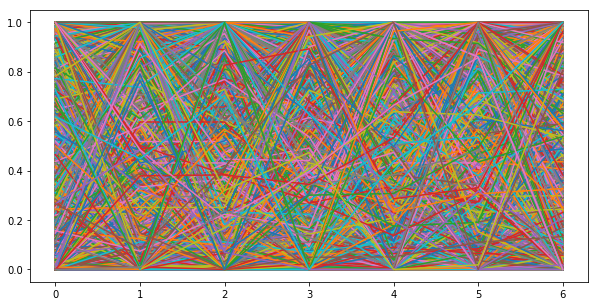

In [18]:
# plot for reference
plt.figure(figsize=(10, 5))
for m_id, group in tr_df_daily_train.groupby(['card_id']):
    plt.plot(np.arange(group.shape[0]), group['purchase_amount_exp_minmax'])

**pivoted sales**

In [19]:
# pivot sales
tr_df_daily_pivoted_train = tr_df_daily_train.pivot_table(values = 'purchase_amount_exp_minmax', index = 'card_id', columns='purchase_date')
tr_df_daily_pivoted_train = tr_df_daily_pivoted_train.interpolate(axis = 1, limit_direction='both')
print('Pivoted shape:', tr_df_daily_pivoted_train.shape)
tr_df_daily_pivoted_train.head(1)

Pivoted shape: (5000, 7)


purchase_date,0,1,2,3,4,5,6
card_id,,,,,,,
C_ID_000c778b05,0.0,0.036491,0.362543,0.054271,1.0,0.251333,0.151808


**cluster by euclidean distance between ts **

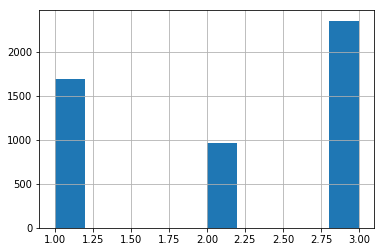

In [21]:
Z = hierarchy.linkage(np.matrix(tr_df_daily_pivoted_train.values), method = 'ward')
fcluster = hierarchy.fcluster(Z, best_n_clusters, criterion='maxclust')

cluster_result = tr_df_daily_pivoted_train.reset_index()[['card_id']].copy()
cluster_result['cluster'] = fcluster

cluster_result.cluster.hist()

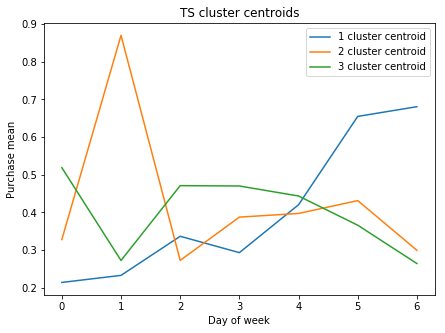

In [22]:
if 'cluster' in tr_df_daily_train.columns:
    tr_df_daily_train.drop('cluster', 1, inplace=True)
tr_df_daily_train = tr_df_daily_train.merge(cluster_result, on = 'card_id', how = 'left')

plot_df = tr_df_daily_train.groupby(['cluster', 'purchase_date'], as_index = False).purchase_amount_exp_minmax.mean()
plt.figure(figsize=(7, 5))
for cl, group in plot_df.groupby(['cluster']):
    plt.plot(group['purchase_date'], group['purchase_amount_exp_minmax'], label = '%s cluster centroid' % cl)
plt.legend()
plt.title('TS cluster centroids')
plt.ylabel('Purchase mean')
plt.xlabel('Day of week')
plt.show()

**mark by centroids the rest of the train dataset**

In [23]:
# pivot all data
tr_df_daily_pivoted_train = tr_df_daily.pivot_table(values = 'purchase_amount_exp_minmax', index = 'card_id', columns='purchase_date')
for c in tr_df_daily_pivoted_train.columns:
    tr_df_daily_pivoted_train[c].fillna(tr_df_daily_pivoted_train[c].median(), inplace = True)
print('Pivoted shape:', tr_df_daily_pivoted_train.shape)
tr_df_daily_pivoted_train.head(1)

Pivoted shape: (15000, 7)


purchase_date,0,1,2,3,4,5,6
card_id,,,,,,,
C_ID_0003be3c83,0.46992,0.0,0.537028,1.0,0.969836,0.35977,0.597017


In [24]:
# pivot centroids
centroid_df = plot_df.pivot_table(values = 'purchase_amount_exp_minmax', index = 'cluster', columns='purchase_date')
centroid_df.head(1)

purchase_date,0,1,2,3,4,5,6
cluster,,,,,,,
1,0.213727,0.232544,0.336447,0.292925,0.420231,0.655064,0.680876


In [25]:
%%time
# mark train by closes centroid
if 'cluster' in tr_df_daily_pivoted_train.columns:
    tr_df_daily_pivoted_train.drop('cluster', 1, inplace=True)
for i, row in tr_df_daily_pivoted_train.iterrows():
    min_dist = 100000
    cluster = -1
    for j, j_row in centroid_df.iterrows():
        dist = euclid_dist(row.values, j_row.values)
        if dist < min_dist:
            min_dist = dist
            cluster = j
        
    tr_df_daily_pivoted_train.loc[i, 'cluster'] = cluster

CPU times: user 7.21 s, sys: 14.3 ms, total: 7.22 s
Wall time: 7.21 s


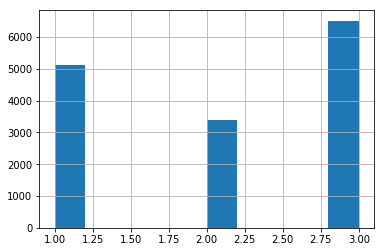

In [26]:
tr_df_daily_pivoted_train.cluster.hist()

In [27]:
# save time series clustering results
ts_clust_result = tr_df_daily_pivoted_train.reset_index()[['card_id', 'cluster']]
ts_clust_result.head(1)

purchase_date,card_id,cluster
0,C_ID_0003be3c83,3.0


**add to train and check single cluster accuracy**

In [28]:
if 'ts_cluster' in train.columns:
    train.drop('ts_cluster', 1, inplace=True)
train = train.merge(ts_clust_result.rename(columns = {'cluster':'ts_cluster'}), on = 'card_id', how = 'left')

In [29]:
x_train, x_test, y_train, y_test= train_test_split(train[elo_train_columns + ['ts_cluster']], train['target'], random_state = 42)

catb_cv = ctb.cv(pool = ctb.Pool(x_train, y_train), params=params, nfold=10, num_boost_round = 10000, early_stopping_rounds=25, verbose_eval=False)
best_it = catb_cv.shape[0]
print('baseline best_it:', best_it)

ctb_model = ctb.train(pool = ctb.Pool(x_train, y_train), params=params, num_boost_round = best_it, verbose_eval=False)
single_clustering_error_ts = np.sqrt(mean_squared_error(y_test, ctb_model.predict(x_test)))
print('single ts clustering rmse:', single_clustering_error_ts)

diff_error_ts = base_error - single_clustering_error_ts
if diff_error_ts > 0:
    print('Error improved by:', diff_error_ts)
else:
    print('Error worsen by:', diff_error_ts)

baseline best_it: 31
single ts clustering rmse: 4.096733490300436
Error worsen by: -0.0008291892876401974


# Graph clustering

In [30]:
from joblib import Parallel, delayed
from multiprocessing import Manager

In [31]:
# data for future adj matrix
adj_df = tr_df[['card_id', 'merchant_category_id']].drop_duplicates().copy()
adj_df.head(1)

,card_id,merchant_category_id
5430,C_ID_3917d75318,307


In [32]:
# find merchant categories for user
adj_dict = {}
for c_id, group in adj_df.groupby(['card_id']):
    m_id_vals = group['merchant_category_id'].values
    adj_dict.update({c_id:set(m_id_vals)})

In [33]:
# make adj matrix, where users are indexes and are conneted if buying similar merchant groups (> 50% similar)
def make_adj_matrix(i):
    adj_list = []
    for c in list(adj_dict.keys()):
        vals = adj_dict.get(i)
        perc = vals.intersection(adj_dict.get(c))
        if perc is not None and len(perc) > len(vals) * 0.5:
            adj_list.append(1)
        else:
            adj_list.append(0)
    adj_matrix.append(adj_list)
    
manager = Manager()
adj_matrix = manager.list()
Parallel(n_jobs = 22, verbose=1)(delayed(make_adj_matrix)(i) for i in list(adj_dict.keys()))
adj_matrix = list(adj_matrix)
adj_matrix = np.matrix(adj_matrix)

[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 764 tasks      | elapsed:    1.8s
[Parallel(n_jobs=22)]: Done 2764 tasks      | elapsed:    6.4s
[Parallel(n_jobs=22)]: Done 5564 tasks      | elapsed:   13.1s
[Parallel(n_jobs=22)]: Done 9164 tasks      | elapsed:   20.6s
[Parallel(n_jobs=22)]: Done 13564 tasks      | elapsed:   30.8s
[Parallel(n_jobs=22)]: Done 15000 out of 15000 | elapsed:   33.8s finished


In [34]:
# perform Spectral clustering on constructed adj matrix

import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import metrics

sc = SpectralClustering(best_n_clusters, affinity='precomputed', n_init=100)
sc.fit(adj_matrix)

adj_res = pd.DataFrame(list(adj_dict.keys()), columns=['card_id'])
adj_res['graph_cluster'] = sc.labels_

/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:883: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


In [35]:
adj_res.graph_cluster.value_counts()

0    7092
2    5735
1    2173
Name: graph_cluster, dtype: int64

In [36]:
adj_res.head(1)

,card_id,graph_cluster
0,C_ID_f74033302e,0


**add to train and check single cluster accuracy**

In [37]:
if 'graph_cluster' in train.columns:
    train.drop('graph_cluster', 1, inplace=True)
train = train.merge(adj_res, on = 'card_id', how = 'left')

In [38]:
x_train, x_test, y_train, y_test= train_test_split(train[elo_train_columns + ['graph_cluster']], train['target'], random_state = 42)

catb_cv = ctb.cv(pool = ctb.Pool(x_train, y_train), params=params, nfold=10, num_boost_round = 10000, early_stopping_rounds=25, verbose_eval=False)
best_it = catb_cv.shape[0]
print('baseline best_it:', best_it)

ctb_model = ctb.train(pool = ctb.Pool(x_train, y_train), params=params, num_boost_round = best_it, verbose_eval=False)
single_clustering_error_ts = np.sqrt(mean_squared_error(y_test, ctb_model.predict(x_test)))
print('single ts clustering rmse:', single_clustering_error_ts)

diff_error_ts = base_error - single_clustering_error_ts
if diff_error_ts > 0:
    print('Error improved by:', diff_error_ts)
else:
    print('Error worsen by:', diff_error_ts)

baseline best_it: 29
single ts clustering rmse: 4.093629210672137
Error improved by: 0.0022750903406594247


# Ensemble clusters

In [39]:
train.head(1)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,card_num_transactions,purchase_amount_mean,cluster,ts_cluster,graph_cluster
0,2017-09,C_ID_dfa21fc124,3,2,1,2.13585,22.0,-0.616629,1.0,3.0,2


**drop uncertain cluster points**

In [40]:
train['ens_cluster'] = train['cluster'].astype('int').astype('str') + '_' + train['ts_cluster'].astype('int').astype('str') + '_' + train['graph_cluster'].astype('int').astype('str')

In [41]:
keep_ens_clusters = train.ens_cluster.value_counts().index[:-24].values
train_without_clusters = train[train.ens_cluster.isin(keep_ens_clusters)]
x_train, x_test, y_train, y_test= train_test_split(train_without_clusters[elo_train_columns + ['ens_cluster']], train_without_clusters['target'], random_state = 42)

x_train.reset_index(inplace=True, drop = True)
y_train.reset_index(inplace=True, drop = True)
x_train = x_train[x_train.ens_cluster.isin(keep_ens_clusters)]
y_train = y_train.iloc[x_train.index]

catb_cv = ctb.cv(pool = ctb.Pool(x_train.drop('ens_cluster', 1), y_train), params=params, nfold=10, num_boost_round = 10000, early_stopping_rounds=25, verbose_eval=False)
best_it = catb_cv.shape[0]
print('baseline best_it:', best_it)

ctb_model = ctb.train(pool = ctb.Pool(x_train.drop('ens_cluster', 1), y_train), params=params, num_boost_round = best_it, verbose_eval=False)
single_clustering_error_ts = np.sqrt(mean_squared_error(y_test, ctb_model.predict(x_test.drop('ens_cluster', 1))))
print('single ts clustering rmse:', single_clustering_error_ts)

diff_error_ts = base_error - single_clustering_error_ts
if diff_error_ts > 0:
    print('Error improved by:', diff_error_ts)
else:
    print('Error worsen by:', diff_error_ts)

baseline best_it: 29
single ts clustering rmse: 3.1726061095692835
Error improved by: 0.9232981914435126


In [42]:
# prepare data for clustering
cluster_columns = ['card_num_transactions', 'purchase_amount_mean']#, 'feature_1_enc', 'feature_2_enc', 'feature_3_enc']
x_train, x_test, y_train, y_test= train_test_split(train[train.ens_cluster.isin(keep_ens_clusters)][cluster_columns], train[train.ens_cluster.isin(keep_ens_clusters)]['target'], random_state = 42)

ss = StandardScaler()
x_train.loc[:, :] = ss.fit_transform(x_train)
x_test.loc[:, :] = ss.transform(x_test)

In [43]:
# fit alg
km = KMeans(n_clusters = best_n_clusters, random_state=42, n_jobs=-1)
km.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

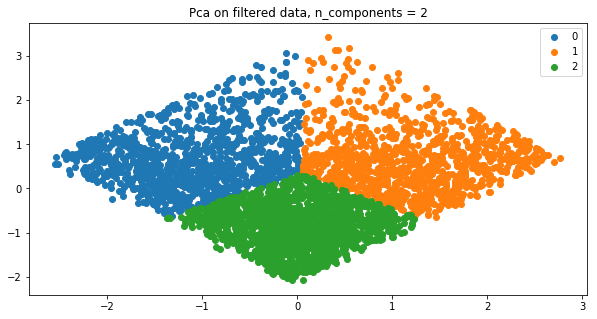

In [44]:
pca = PCA(n_components=2)
plot_df = x_train.copy()
x_train_pca = pca.fit_transform(x_train)
plot_df['pca_1'] = x_train_pca[:, 0]
plot_df['pca_2'] = x_train_pca[:, 1]
plot_df['cluster'] = km.predict(x_train)

plt.figure(figsize=(10, 5))
for cluster, group in plot_df.groupby(['cluster']):
    plt.scatter(group.pca_1, group.pca_2, label = cluster)
plt.legend()
plt.title('Pca on filtered data, n_components = 2')
plt.show()